In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import copy
import os
import joblib

df_merged = pd.read_csv('./energy_consumption_with_weather.csv')
df_no_feature_engineering = pd.read_csv('./energy_weather_no_feature_engineering.csv')

# Force the index to be the time column
df_merged.set_index('time', inplace=True)
df_no_feature_engineering.set_index('time', inplace=True)

target_series = df_merged["total load actual"].astype(float)

df_merged.head()

,total load actual,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,...,wind_speed_lag_24h_prev_day,wind_speed_lag_168h_prev_week,rain_1h_lag_1,rain_1h_lag_2,rain_1h_lag_3,rain_1h_lag_4,rain_1h_lag_5,rain_1h_lag_6,rain_1h_lag_24h_prev_day,rain_1h_lag_168h_prev_week
time,,,,,,,,,,,,,,,,,,,,,
2015-01-07 23:00:00+00:00,26788.0,276.60,268.06,284.55,1020.6,85.4,1.6,319.28,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.12,0.00,0.0
2015-01-08 00:00:00+00:00,25146.0,276.21,267.72,284.35,1020.8,85.4,1.6,267.73,0.0,0.0,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
2015-01-08 01:00:00+00:00,23889.0,275.78,267.38,284.15,1021.0,86.8,1.8,348.01,0.0,0.0,...,1.2,2.4,0.0,0.0,0.0,0.0,0.0,0.00,0.06,0.0
2015-01-08 02:00:00+00:00,23046.0,275.50,267.38,283.85,1021.4,86.8,1.8,350.89,0.0,0.0,...,1.4,2.4,0.0,0.0,0.0,0.0,0.0,0.00,0.06,0.0
2015-01-08 03:00:00+00:00,22587.0,275.35,267.38,283.85,1021.4,87.0,1.4,344.09,0.0,0.0,...,1.2,2.4,0.0,0.0,0.0,0.0,0.0,0.00,0.06,0.0


In [2]:
target_series.head()

,total load actual
time,
2015-01-07 23:00:00+00:00,26788.0
2015-01-08 00:00:00+00:00,25146.0
2015-01-08 01:00:00+00:00,23889.0
2015-01-08 02:00:00+00:00,23046.0
2015-01-08 03:00:00+00:00,22587.0


In [3]:
def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error, handling zeros in y_true."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return 0.0 if np.all(y_pred == 0) else float('inf')
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def create_sequences(data, sequence_length):
    """Creates sequences from time series data."""
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i : (i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [4]:
# Parameters for LSTM
sequence_length = 24
n_features = 1
hidden_size = 50
num_layers = 1
learning_rate = 0.001
num_epochs_overfit = 100
batch_size = 16

small_data_size = 30 * 24
overfit_data_raw = target_series.iloc[:small_data_size].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))
overfit_data_scaled = scaler.fit_transform(overfit_data_raw)

X_overfit, y_overfit = create_sequences(
    overfit_data_scaled.flatten(), sequence_length
)

X_overfit_tensor = torch.from_numpy(X_overfit).float().unsqueeze(-1)
y_overfit_tensor = torch.from_numpy(y_overfit).float().unsqueeze(-1)

overfit_dataset = TensorDataset(X_overfit_tensor, y_overfit_tensor)
overfit_loader = DataLoader(
    overfit_dataset, batch_size=batch_size, shuffle=True
)
eval_overfit_loader = DataLoader(
    overfit_dataset, batch_size=batch_size, shuffle=False
)

print(f"Shape of X_overfit_tensor: {X_overfit_tensor.shape}")
print(f"Shape of y_overfit_tensor: {y_overfit_tensor.shape}")

Shape of X_overfit_tensor: torch.Size([696, 24, 1])
Shape of y_overfit_tensor: torch.Size([696, 1])


In [5]:
# Simple LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(
            x.device
        )
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(
            x.device
        )
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model
lstm_model = LSTMModel(
    input_size=n_features,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=1,
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

Using device: cuda


In [6]:
def train_lstm_model(
    model, data_loader, optimizer, criterion, num_epochs, device
):
    print("\nStarting LSTM training for overfitting check (unscaled data)...")
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i, (sequences, labels) in enumerate(data_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(data_loader)
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.2f}"
            )
    print("Finished training for overfitting check.")


def evaluate_lstm_model(model, data_loader, criterion, device):
    print(
        "\nEvaluating LSTM model on the small (overfit) dataset (unscaled data)..."
    )
    model.eval()
    total_loss = 0
    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_predictions.extend(outputs.cpu().numpy().flatten().tolist())
            all_actuals.extend(labels.cpu().numpy().flatten().tolist())

    avg_loss = total_loss / len(data_loader)
    mae = mean_absolute_error(all_actuals, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_actuals, all_predictions))
    mape = calculate_mape(np.array(all_actuals), np.array(all_predictions))

    print(f"Evaluation on small dataset - Average Loss: {avg_loss:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    return {"loss": avg_loss, "MAE": mae, "RMSE": rmse, "MAPE": mape}

In [7]:
# Train the model on the small subset
train_lstm_model(
    lstm_model, overfit_loader, optimizer, criterion, num_epochs_overfit, device
)

overfit_metrics = evaluate_lstm_model(
    lstm_model, eval_overfit_loader, criterion, device
)


Starting LSTM training for overfitting check (unscaled data)...
Epoch [1/100], Loss: 0.20
Epoch [10/100], Loss: 0.01
Epoch [20/100], Loss: 0.01
Epoch [30/100], Loss: 0.01
Epoch [40/100], Loss: 0.00
Epoch [50/100], Loss: 0.00
Epoch [60/100], Loss: 0.00
Epoch [70/100], Loss: 0.00
Epoch [80/100], Loss: 0.00
Epoch [90/100], Loss: 0.00
Epoch [100/100], Loss: 0.00
Finished training for overfitting check.

Evaluating LSTM model on the small (overfit) dataset (unscaled data)...
Evaluation on small dataset - Average Loss: 0.00
MAE:  0.04
RMSE: 0.05
MAPE: 35.10%


In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        lstm_dropout = dropout_prob if num_layers > 1 else 0.0
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=lstm_dropout
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [9]:
def prepare_full_data(
    series_data,
    train_ratio=0.7,
    val_ratio=0.15,
    sequence_length=24,
    batch_size=32,
    n_features=1
):
    print("\n--- Preparing Full Dataset for LSTM ---")
    if not isinstance(series_data, pd.Series):
        series_data = pd.Series(series_data)

    n = len(series_data)
    train_end_idx = int(n * train_ratio)
    val_end_idx = int(n * (train_ratio + val_ratio))

    train_raw = series_data.iloc[:train_end_idx].values.reshape(-1, n_features)
    val_raw = series_data.iloc[train_end_idx:val_end_idx].values.reshape(-1, n_features)
    test_raw = series_data.iloc[val_end_idx:].values.reshape(-1, n_features)

    print(f"Raw data shapes: Train={train_raw.shape}, Val={val_raw.shape}, Test={test_raw.shape}")

    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_scaled = scaler.fit_transform(train_raw)
    val_scaled = scaler.transform(val_raw)
    test_scaled = scaler.transform(test_raw)

    X_train, y_train = create_sequences(train_scaled.flatten(), sequence_length)
    X_val, y_val = create_sequences(val_scaled.flatten(), sequence_length)
    X_test, y_test = create_sequences(test_scaled.flatten(), sequence_length)

    if X_train.size == 0 or X_val.size == 0 or X_test.size == 0:
        raise ValueError(
            "One of the datasets (train, val, or test) is too small to create sequences "
            "with the given sequence_length. Adjust ratios or sequence_length."
            )

    print(f"Sequence shapes: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Sequence shapes: X_val={X_val.shape}, y_val={y_val.shape}")
    print(f"Sequence shapes: X_test={X_test.shape}, y_test={y_test.shape}")

    X_train_tensor = torch.from_numpy(X_train).float().reshape(-1, sequence_length, n_features)
    y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(-1)
    X_val_tensor = torch.from_numpy(X_val).float().reshape(-1, sequence_length, n_features)
    y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(-1)
    X_test_tensor = torch.from_numpy(X_test).float().reshape(-1, sequence_length, n_features)
    y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(-1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    print("Data preparation complete.")
    return train_loader, val_loader, test_loader, scaler

In [10]:
def train_model_with_early_stopping(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    num_epochs,
    device,
    patience=10,
    min_delta=0.00001,
    model_save_path="best_lstm_model.pth"
):
    print("\n--- Starting Full LSTM Training with Early Stopping ---")
    best_val_loss = float("inf")
    epochs_no_improve = 0
    best_model_state_dict = None

    for epoch in range(num_epochs):
        model.train()
        train_loss_epoch = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_epoch += loss.item()
        avg_train_loss = train_loss_epoch / len(train_loader)

        model.eval()
        val_loss_epoch = 0
        with torch.no_grad():
            for sequences_val, labels_val in val_loader:
                sequences_val, labels_val = sequences_val.to(device), labels_val.to(device)
                outputs_val = model(sequences_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss_epoch += loss_val.item()
        avg_val_loss = val_loss_epoch / len(val_loader)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}"
        )

        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_model_state_dict = copy.deepcopy(model.state_dict())
            torch.save(best_model_state_dict, model_save_path)
            print(f"Validation loss improved to {best_val_loss:.6f}. Saved best model to {model_save_path}")
        else:
            epochs_no_improve += 1
            print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best val loss: {best_val_loss:.6f}")
            break

    if best_model_state_dict:
        print(f"Loading best model weights from epoch with val_loss: {best_val_loss:.6f}")
        model.load_state_dict(best_model_state_dict)
    else:
        print("Training finished. No improvement found or early stopping not triggered. Using last model state.")

    print("--- Finished Full LSTM Training ---")
    return model


def evaluate_model(model, data_loader, criterion, scaler, device, dataset_name="Test"):
    print(f"\n--- Evaluating LSTM model on {dataset_name} set ---")
    model.eval()
    total_loss_scaled = 0
    all_predictions_inversed = []
    all_actuals_inversed = []

    with torch.no_grad():
        for sequences, labels_scaled_batch in data_loader:
            sequences, labels_scaled_batch = sequences.to(device), labels_scaled_batch.to(device)

            outputs_scaled_batch = model(sequences)
            loss_scaled = criterion(outputs_scaled_batch, labels_scaled_batch)
            total_loss_scaled += loss_scaled.item()

            predictions_inversed_batch = scaler.inverse_transform(outputs_scaled_batch.cpu().numpy())
            actuals_inversed_batch = scaler.inverse_transform(labels_scaled_batch.cpu().numpy())

            all_predictions_inversed.extend(predictions_inversed_batch.flatten().tolist())
            all_actuals_inversed.extend(actuals_inversed_batch.flatten().tolist())

    avg_loss_scaled = total_loss_scaled / len(data_loader)
    mae = mean_absolute_error(all_actuals_inversed, all_predictions_inversed)
    rmse = np.sqrt(mean_squared_error(all_actuals_inversed, all_predictions_inversed))
    mape = calculate_mape(np.array(all_actuals_inversed), np.array(all_predictions_inversed))

    print(f"Evaluation on {dataset_name} set - Average Scaled Loss: {avg_loss_scaled:.6f}")
    print(f"MAE (original scale):  {mae:.2f}")
    print(f"RMSE (original scale): {rmse:.2f}")
    print(f"MAPE (original scale): {mape:.2f}%")

    return {
        "loss_scaled": avg_loss_scaled,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "actuals": all_actuals_inversed,
        "predictions": all_predictions_inversed
    }

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_predictions(
    timestamps, actuals, predictions, title="Time Series Forecast", plot_subset_size=None
):
    """
    Plots actual vs. predicted time series data.

    Args:
        timestamps (pd.DatetimeIndex or similar): Timestamps for the x-axis.
        actuals (list or np.array): The true values.
        predictions (list or np.array): The predicted values.
        title (str): The title of the plot.
        plot_subset_size (int, optional): Number of points to plot from the end of the series.
                                          If None, plots all data.
    """
    plt.figure(figsize=(15, 7))

    if plot_subset_size and plot_subset_size < len(timestamps):
        timestamps_to_plot = timestamps[-plot_subset_size:]
        actuals_to_plot = actuals[-plot_subset_size:]
        predictions_to_plot = predictions[-plot_subset_size:]
    else:
        timestamps_to_plot = timestamps
        actuals_to_plot = actuals
        predictions_to_plot = predictions

    plt.plot(timestamps_to_plot, actuals_to_plot, label="Actual Values", color="blue", marker='.', linestyle='-')
    plt.plot(timestamps_to_plot, predictions_to_plot, label="Predicted Values", color="red", marker='.', linestyle='--')

    plt.title(title, fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Energy Demand", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))
    plt.gcf().autofmt_xdate()

    plt.tight_layout()
    plt.show()

In [12]:
from itertools import product
import time
import json
from datetime import datetime

def hyperparameter_grid_search(
    target_series,
    param_grid,
    train_ratio=0.7,
    val_ratio=0.15,
    n_features=1,
    max_epochs=50,
    patience=10,
    min_delta=0.00001,
    device=None,
    results_save_path="grid_search_results.json"
):
    """
    Performs grid search hyperparameter tuning for LSTM model.

    Args:
        target_series: The time series data
        param_grid: Dictionary containing parameter ranges to search
        train_ratio: Training data ratio
        val_ratio: Validation data ratio
        n_features: Number of input features
        max_epochs: Maximum epochs per configuration
        patience: Early stopping patience
        min_delta: Minimum improvement for early stopping
        device: PyTorch device
        results_save_path: Path to save results JSON

    Returns:
        Dictionary with best parameters and all results
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Starting hyperparameter grid search on {device}")
    print(f"Parameter grid: {param_grid}")

    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    param_combinations = list(product(*param_values))

    print(f"Total combinations to test: {len(param_combinations)}")

    results = []
    best_val_loss = float('inf')
    best_params = None
    best_model_state = None

    start_time = time.time()

    for i, params in enumerate(param_combinations):
        param_dict = dict(zip(param_names, params))
        print(f"\n{'='*60}")
        print(f"Configuration {i+1}/{len(param_combinations)}: {param_dict}")
        print(f"{'='*60}")

        try:
            train_loader, val_loader, test_loader, scaler = prepare_full_data(
                target_series,
                train_ratio=train_ratio,
                val_ratio=val_ratio,
                sequence_length=param_dict['sequence_length'],
                batch_size=param_dict['batch_size'],
                n_features=n_features
            )

            # Initialize model with current parameters
            model = LSTMModel(
                input_size=n_features,
                hidden_size=param_dict['hidden_size'],
                num_layers=param_dict['num_layers'],
                output_size=1,
                dropout_prob=param_dict['dropout_prob']
            ).to(device)

            # Initialize optimizer
            if param_dict['optimizer'] == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=param_dict['learning_rate'])
            elif param_dict['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=param_dict['learning_rate'])
            elif param_dict['optimizer'] == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=param_dict['learning_rate'])

            # Initialize loss function
            if param_dict['loss_function'] == 'MSE':
                criterion = nn.MSELoss()
            elif param_dict['loss_function'] == 'MAE':
                criterion = nn.L1Loss()
            elif param_dict['loss_function'] == 'Huber':
                criterion = nn.HuberLoss()

            # Train model
            config_start_time = time.time()
            trained_model = train_model_with_early_stopping(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                optimizer=optimizer,
                criterion=criterion,
                num_epochs=max_epochs,
                device=device,
                patience=patience,
                min_delta=min_delta,
                model_save_path=f"temp_model_config_{i}.pth"
            )
            config_train_time = time.time() - config_start_time

            # Evaluate on validation set
            val_metrics = evaluate_model(
                model=trained_model,
                data_loader=val_loader,
                criterion=criterion,
                scaler=scaler,
                device=device,
                dataset_name="Validation"
            )

            result = {
                'config_id': i,
                'parameters': param_dict,
                'val_loss': val_metrics['loss_scaled'],
                'val_mae': val_metrics['MAE'],
                'val_rmse': val_metrics['RMSE'],
                'val_mape': val_metrics['MAPE'],
                'training_time_seconds': config_train_time,
                'timestamp': datetime.now().isoformat()
            }
            results.append(result)

            # Check if this is the best model so far
            if val_metrics['loss_scaled'] < best_val_loss:
                best_val_loss = val_metrics['loss_scaled']
                best_params = param_dict.copy()
                best_model_state = copy.deepcopy(trained_model.state_dict())
                print(f"🎉 New best model found! Val Loss: {best_val_loss:.6f}")

            print(f"Configuration {i+1} completed in {config_train_time:.2f}s")
            print(f"Val Loss: {val_metrics['loss_scaled']:.6f}, Val MAE: {val_metrics['MAE']:.2f}")

            # Clean up temporary model file
            temp_file = f"temp_model_config_{i}.pth"
            if os.path.exists(temp_file):
                os.remove(temp_file)

        except Exception as e:
            print(f"❌ Error in configuration {i+1}: {str(e)}")
            result = {
                'config_id': i,
                'parameters': param_dict,
                'error': str(e),
                'timestamp': datetime.now().isoformat()
            }
            results.append(result)
            continue

    total_time = time.time() - start_time

    # Save results to JSON
    final_results = {
        'search_metadata': {
            'total_configurations': len(param_combinations),
            'successful_runs': len([r for r in results if 'error' not in r]),
            'failed_runs': len([r for r in results if 'error' in r]),
            'total_time_seconds': total_time,
            'total_time_formatted': f"{total_time//3600:.0f}h {(total_time%3600)//60:.0f}m {total_time%60:.0f}s",
            'search_completed': datetime.now().isoformat()
        },
        'best_configuration': {
            'parameters': best_params,
            'validation_loss': best_val_loss,
            'model_state_available': best_model_state is not None
        },
        'all_results': results
    }

    # Save to file
    with open(results_save_path, 'w') as f:
        json.dump(final_results, f, indent=2)

    print(f"\n{'='*80}")
    print(f"GRID SEARCH COMPLETED!")
    print(f"{'='*80}")
    print(f"Total time: {total_time//3600:.0f}h {(total_time%3600)//60:.0f}m {total_time%60:.0f}s")
    print(f"Best validation loss: {best_val_loss:.6f}")
    print(f"Best parameters: {best_params}")
    print(f"Results saved to: {results_save_path}")

    return final_results, best_model_state

In [ ]:
# Define hyperparameter search space
hyperparameter_grid = {
    'sequence_length': [24, 24*3, 24*7],
    'hidden_size': [64, 128, 256],
    'num_layers': [1, 2, 3],
    'dropout_prob': [0.0, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'batch_size': [128],
    'optimizer': ['Adam'],
    'loss_function': ['MSE', 'MAE']
}

quick_hyperparameter_grid = {
    'sequence_length': [24, 24*7],
    'hidden_size': [64, 128],
    'num_layers': [1, 2],
    'dropout_prob': [0.0, 0.2],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [128],
    'optimizer': ['Adam'],
    'loss_function': ['MSE']
}

print("Starting hyperparameter tuning...")

search_results, best_model_weights = hyperparameter_grid_search(
    target_series=target_series,
    param_grid=quick_hyperparameter_grid,
    train_ratio=0.7,
    val_ratio=0.15,
    n_features=1,
    max_epochs=30,
    patience=8,
    device=device,
    results_save_path="lstm_grid_search_results.json"
)

In [13]:
import json

def analyze_grid_search_results(results_file="lstm_grid_search_results.json"):
    """Analyze and visualize grid search results."""

    with open(results_file, 'r') as f:
        data = json.load(f)

    successful_results = [r for r in data['all_results'] if 'error' not in r]

    if not successful_results:
        print("No successful results found!")
        return

    import pandas as pd

    analysis_data = []
    for result in successful_results:
        row = result['parameters'].copy()
        row.update({
            'val_loss': result['val_loss'],
            'val_mae': result['val_mae'],
            'val_rmse': result['val_rmse'],
            'val_mape': result['val_mape'],
            'training_time': result['training_time_seconds']
        })
        analysis_data.append(row)

    df = pd.DataFrame(analysis_data)

    print("\n📊 GRID SEARCH ANALYSIS")
    print("="*50)
    print(f"Total successful configurations: {len(df)}")
    print(f"\nTop 5 configurations by validation loss:")
    top_5 = df.nsmallest(5, 'val_loss')
    print(top_5.to_string(index=False))

    print(f"\n📈 Parameter Impact Analysis:")
    for param in ['sequence_length', 'hidden_size', 'num_layers', 'dropout_prob', 'learning_rate']:
        if param in df.columns:
            correlation = df[param].corr(df['val_loss'])
            print(f"{param}: correlation with val_loss = {correlation:.3f}")

    df.to_csv("grid_search_detailed_results.csv", index=False)
    print(f"\nDetailed results saved to: grid_search_detailed_results.csv")

    return df

In [ ]:
analysis_df = analyze_grid_search_results()

Using device: cuda
Model will be saved to: best_lstm_energy_model.pth
Scaler will be saved to: energy_data_scaler.joblib

--- Preparing Full Dataset for LSTM ---
Raw data shapes: Train=(8742, 1), Val=(1873, 1), Test=(1874, 1)
Sequence shapes: X_train=(8574, 168), y_train=(8574,)
Sequence shapes: X_val=(1705, 168), y_val=(1705,)
Sequence shapes: X_test=(1706, 168), y_test=(1706,)
Data preparation complete.
Scaler saved to energy_data_scaler.joblib

--- Starting Full LSTM Training with Early Stopping ---
Epoch [1/100], Train Loss: 0.086303, Val Loss: 0.023990
Validation loss improved to 0.023990. Saved best model to best_lstm_energy_model.pth
Epoch [2/100], Train Loss: 0.013504, Val Loss: 0.008279
Validation loss improved to 0.008279. Saved best model to best_lstm_energy_model.pth
Epoch [3/100], Train Loss: 0.008695, Val Loss: 0.006786
Validation loss improved to 0.006786. Saved best model to best_lstm_energy_model.pth
Epoch [4/100], Train Loss: 0.008339, Val Loss: 0.008393
Validation lo

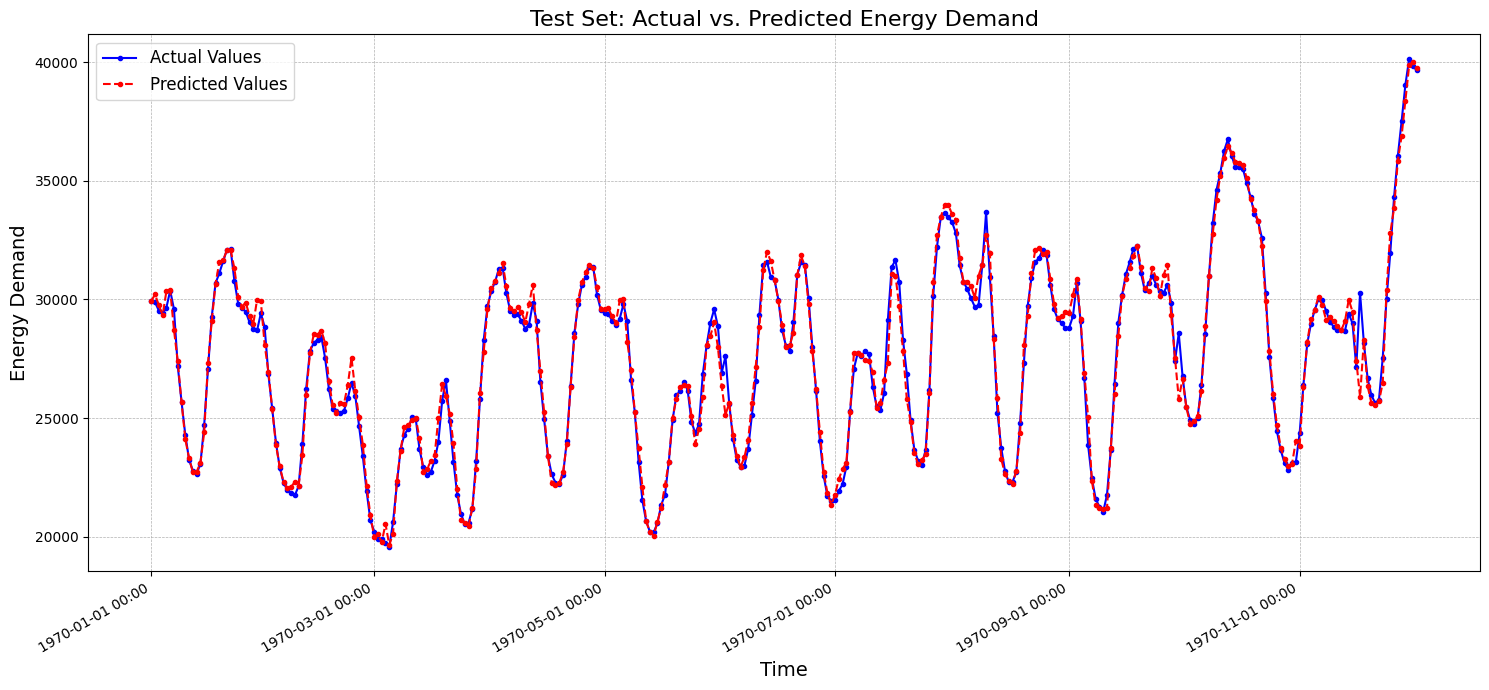

In [ ]:
SEQUENCE_LENGTH = 24 * 7
BATCH_SIZE = 128
N_FEATURES = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT_PROB = 0
LEARNING_RATE = 0.0010
NUM_EPOCHS = 100
PATIENCE_EARLY_STOP = 10
MIN_DELTA_EARLY_STOP = 0.00001
MODEL_SAVE_PATH = os.path.join("best_lstm_energy_model.pth")
SCALER_SAVE_PATH = os.path.join("energy_data_scaler.joblib")

TRAIN_RATIO = 0.7
VAL_RATIO = 0.15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Model will be saved to: {MODEL_SAVE_PATH}")
print(f"Scaler will be saved to: {SCALER_SAVE_PATH}")

try:
    train_loader, val_loader, test_loader, scaler = prepare_full_data(
        target_series,
        train_ratio=TRAIN_RATIO,
        val_ratio=VAL_RATIO,
        sequence_length=SEQUENCE_LENGTH,
        batch_size=BATCH_SIZE,
        n_features=N_FEATURES
    )
    joblib.dump(scaler, SCALER_SAVE_PATH)
    print(f"Scaler saved to {SCALER_SAVE_PATH}")
except ValueError as e:
    print(f"Error during data preparation: {e}")
    exit()

lstm_model = LSTMModel(
    input_size=N_FEATURES,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=1,
    dropout_prob=DROPOUT_PROB
).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

trained_lstm_model = train_model_with_early_stopping(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=NUM_EPOCHS,
    device=device,
    patience=PATIENCE_EARLY_STOP,
    min_delta=MIN_DELTA_EARLY_STOP,
    model_save_path=MODEL_SAVE_PATH
)

print("\n--- Final Evaluation on Test Set (using best model from training) ---")
if os.path.exists(MODEL_SAVE_PATH):
      print(f"Confirming: Loading best model from {MODEL_SAVE_PATH} for test evaluation.")
      trained_lstm_model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=device))
else:
    print(f"Warning: Best model file not found at {MODEL_SAVE_PATH}. Evaluating with the last state of the model from training.")

test_metrics = evaluate_model(
    model=trained_lstm_model,
    data_loader=test_loader,
    criterion=criterion,
    scaler=scaler,
    device=device,
    dataset_name="Test"
)
print("\nFinal Test Set Performance:")
for metric, value in test_metrics.items():
    if metric not in ["actuals", "predictions"]:
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) and metric != "MAPE" else f"  {metric}: {value:.2f}%")

if "actuals" in test_metrics and "predictions" in test_metrics:
    test_actuals = test_metrics["actuals"]
    test_predictions = test_metrics["predictions"]

    n_total = len(target_series)
    val_end_idx_for_plot = int(n_total * (TRAIN_RATIO + VAL_RATIO))

    num_predictions = len(test_predictions)

    test_predictions_start_original_idx = val_end_idx_for_plot + SEQUENCE_LENGTH

    if test_predictions_start_original_idx + num_predictions > n_total:
        print("Warning: Calculated end index for plotting exceeds series length. Adjusting.")
        num_predictions = n_total - test_predictions_start_original_idx

    timestamps_for_plot = target_series.index[
        test_predictions_start_original_idx : test_predictions_start_original_idx + num_predictions
    ]

    if len(timestamps_for_plot) == len(test_actuals) and len(timestamps_for_plot) == len(test_predictions):
        plot_predictions(
            timestamps_for_plot,
            test_actuals,
            test_predictions,
            title="Test Set: Actual vs. Predicted Energy Demand",
            plot_subset_size=24 * 14
        )
    else:
        print("Warning: Mismatch in lengths of timestamps, actuals, or predictions. Skipping plot.")
        print(f"Timestamps length: {len(timestamps_for_plot)}")
        print(f"Actuals length: {len(test_actuals)}")
        print(f"Predictions length: {len(test_predictions)}")

In [17]:
# Define features to use for multivariate model
SELECTED_FEATURES = [
    'total load actual',
    'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
    'wind_speed', 'rain_1h', 'clouds_all',
    'hour', 'day_of_week', 'month', 'is_holiday',
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos'
]

# Prepare multivariate data
multivariate_data = df_merged[SELECTED_FEATURES].copy()

# Remove any rows with NaN values
multivariate_data = multivariate_data.dropna()

print(f"Selected features: {SELECTED_FEATURES}")
print(f"Multivariate data shape: {multivariate_data.shape}")
print(f"Features count: {len(SELECTED_FEATURES)}")

def create_multivariate_sequences(data, sequence_length, target_column='total load actual'):
    """Creates sequences from multivariate time series data.

    Args:
        data: DataFrame with multiple features
        sequence_length: Length of input sequences
        target_column: Name of the column to predict

    Returns:
        X: sequences of shape (samples, sequence_length, n_features)
        y: targets of shape (samples, 1)
    """
    xs, ys = [], []

    # Get target column index
    target_idx = data.columns.get_loc(target_column)

    for i in range(len(data) - sequence_length):
        # Input sequence: all features for sequence_length time steps
        x = data.iloc[i:(i + sequence_length)].values
        # Target: only the target variable at the next time step
        y = data.iloc[i + sequence_length, target_idx]

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Modified data preparation function for multivariate data
def prepare_multivariate_data(
    data,  # DataFrame with multiple features
    target_column='total load actual',
    train_ratio=0.7,
    val_ratio=0.15,
    sequence_length=24,
    batch_size=32
):
    """Prepare multivariate data for LSTM training."""
    print(f"\n--- Preparing Multivariate Dataset for LSTM ---")
    print(f"Using features: {list(data.columns)}")
    print(f"Target column: {target_column}")

    # Split data chronologically
    n = len(data)
    train_end_idx = int(n * train_ratio)
    val_end_idx = int(n * (train_ratio + val_ratio))

    train_data = data.iloc[:train_end_idx]
    val_data = data.iloc[train_end_idx:val_end_idx]
    test_data = data.iloc[val_end_idx:]

    print(f"Data splits: Train={len(train_data)}, Val={len(val_data)}, Test={len(test_data)}")

    # Scale features (fit scaler ONLY on training data)
    scaler = MinMaxScaler(feature_range=(-1, 1))

    # Scale training data and fit scaler
    train_scaled = pd.DataFrame(
        scaler.fit_transform(train_data),
        columns=data.columns,
        index=train_data.index
    )

    # Scale validation and test data using the fitted scaler
    val_scaled = pd.DataFrame(
        scaler.transform(val_data),
        columns=data.columns,
        index=val_data.index
    )

    test_scaled = pd.DataFrame(
        scaler.transform(test_data),
        columns=data.columns,
        index=test_data.index
    )

    # Create sequences
    X_train, y_train = create_multivariate_sequences(train_scaled, sequence_length, target_column)
    X_val, y_val = create_multivariate_sequences(val_scaled, sequence_length, target_column)
    X_test, y_test = create_multivariate_sequences(test_scaled, sequence_length, target_column)

    print(f"Sequence shapes: X_train={X_train.shape}, y_train={y_train.shape}")
    print(f"Number of features: {X_train.shape[2]}")

    # Convert to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).float()
    y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(-1)

    X_val_tensor = torch.from_numpy(X_val).float()
    y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(-1)

    X_test_tensor = torch.from_numpy(X_test).float()
    y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(-1)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    print(f"DataLoaders created successfully!")
    return train_loader, val_loader, test_loader, scaler

Selected features: ['total load actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'hour', 'day_of_week', 'month', 'is_holiday', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
Multivariate data shape: (34896, 17)
Features count: 17


In [31]:
# Updated parameters for multivariate LSTM
SEQUENCE_LENGTH_MV = 24 * 7
BATCH_SIZE_MV = 64
N_FEATURES_MV = len(SELECTED_FEATURES)
HIDDEN_SIZE_MV = 128
NUM_LAYERS_MV = 2
DROPOUT_PROB_MV = 0.2
LEARNING_RATE_MV = 0.0005
NUM_EPOCHS_MV = 50
PATIENCE_EARLY_STOP_MV = 8
MIN_DELTA_EARLY_STOP_MV = 0.00001
MODEL_SAVE_PATH_MV = "best_lstm_multivariate_model.pth"
SCALER_SAVE_PATH_MV = "multivariate_data_scaler.joblib"

TRAIN_RATIO_MV = 0.7
VAL_RATIO_MV = 0.15

print(f"Multivariate LSTM Configuration:")
print(f"- Number of features: {N_FEATURES_MV}")
print(f"- Sequence length: {SEQUENCE_LENGTH_MV}")
print(f"- Hidden size: {HIDDEN_SIZE_MV}")
print(f"- Features being used: {SELECTED_FEATURES}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare multivariate data
try:
    train_loader_mv, val_loader_mv, test_loader_mv, scaler_mv = prepare_multivariate_data(
        multivariate_data,
        target_column='total load actual',
        train_ratio=TRAIN_RATIO_MV,
        val_ratio=VAL_RATIO_MV,
        sequence_length=SEQUENCE_LENGTH_MV,
        batch_size=BATCH_SIZE_MV
    )
    joblib.dump(scaler_mv, SCALER_SAVE_PATH_MV)
    print(f"Multivariate scaler saved to {SCALER_SAVE_PATH_MV}")
except ValueError as e:
    print(f"Error during multivariate data preparation: {e}")

# Initialize multivariate LSTM model
lstm_model_mv = LSTMModel(
    input_size=N_FEATURES_MV,
    hidden_size=HIDDEN_SIZE_MV,
    num_layers=NUM_LAYERS_MV,
    output_size=1,
    dropout_prob=DROPOUT_PROB_MV
).to(device)

criterion_mv = nn.MSELoss()
optimizer_mv = optim.Adam(lstm_model_mv.parameters(), lr=LEARNING_RATE_MV)

print(f"\nMultivariate LSTM Model:")
print(f"- Input size (features per timestep): {N_FEATURES_MV}")
print(f"- Hidden size: {HIDDEN_SIZE_MV}")
print(f"- Number of layers: {NUM_LAYERS_MV}")
print(f"- Output size: 1")

# Train the multivariate model
print(f"\n=== Training Multivariate LSTM Model ===")
trained_lstm_model_mv = train_model_with_early_stopping(
    model=lstm_model_mv,
    train_loader=train_loader_mv,
    val_loader=val_loader_mv,
    optimizer=optimizer_mv,
    criterion=criterion_mv,
    num_epochs=NUM_EPOCHS_MV,
    device=device,
    patience=PATIENCE_EARLY_STOP_MV,
    min_delta=MIN_DELTA_EARLY_STOP_MV,
    model_save_path=MODEL_SAVE_PATH_MV
)

# Evaluate multivariate model on test set
print("\n=== Evaluating Multivariate LSTM Model ===")
if os.path.exists(MODEL_SAVE_PATH_MV):
    print(f"Loading best multivariate model from {MODEL_SAVE_PATH_MV}")
    trained_lstm_model_mv.load_state_dict(torch.load(MODEL_SAVE_PATH_MV, map_location=device))
else:
    print(f"Warning: Best model file not found. Using current model state.")

Multivariate LSTM Configuration:
- Number of features: 17
- Sequence length: 168
- Hidden size: 128
- Features being used: ['total load actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'hour', 'day_of_week', 'month', 'is_holiday', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
Using device: cuda

--- Preparing Multivariate Dataset for LSTM ---
Using features: ['total load actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'hour', 'day_of_week', 'month', 'is_holiday', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
Target column: total load actual
Data splits: Train=24427, Val=5234, Test=5235
Sequence shapes: X_train=(24259, 168, 17), y_train=(24259,)
Number of features: 17
DataLoaders created successfully!
Multivariate scaler saved to multivariate_data_scaler.joblib

Multivariate LSTM Model:
- Input size (features per timestep): 17
- Hidden size: 128
- Number of layers: 2
- 

In [32]:
def evaluate_multivariate_model(model, data_loader, criterion, scaler, target_column='total load actual', device="cpu", dataset_name="Test"):
    """
    Evaluation function specifically designed for multivariate models.

    Args:
        model: The trained LSTM model
        data_loader: DataLoader for evaluation
        criterion: Loss criterion
        scaler: The MultivaiatescalerScaler used for all features
        target_column: Name of the target column
        device: Device to run evaluation on
        dataset_name: Name for logging
    """
    print(f"\n--- Evaluating Multivariate LSTM model on {dataset_name} set ---")
    model.eval()
    total_loss_scaled = 0
    all_predictions_inversed = []
    all_actuals_inversed = []

    if hasattr(scaler, 'feature_names_in_'):
        feature_names = scaler.feature_names_in_
    else:
        print("Warning: Scaler doesn't have feature names. Assuming target is first column.")
        target_idx = 0

    try:
        target_idx = list(feature_names).index(target_column) if hasattr(scaler, 'feature_names_in_') else 0
    except ValueError:
        print(f"Warning: Target column '{target_column}' not found in scaler features. Using index 0.")
        target_idx = 0

    with torch.no_grad():
        for sequences, labels_scaled_batch in data_loader:
            sequences, labels_scaled_batch = sequences.to(device), labels_scaled_batch.to(device)

            outputs_scaled_batch = model(sequences)
            loss_scaled = criterion(outputs_scaled_batch, labels_scaled_batch)
            total_loss_scaled += loss_scaled.item()

            batch_size = outputs_scaled_batch.shape[0]

            dummy_predictions = np.zeros((batch_size, scaler.n_features_in_))
            dummy_actuals = np.zeros((batch_size, scaler.n_features_in_))

            dummy_predictions[:, target_idx] = outputs_scaled_batch.cpu().numpy().flatten()
            dummy_actuals[:, target_idx] = labels_scaled_batch.cpu().numpy().flatten()

            predictions_inversed_batch = scaler.inverse_transform(dummy_predictions)[:, target_idx]
            actuals_inversed_batch = scaler.inverse_transform(dummy_actuals)[:, target_idx]

            all_predictions_inversed.extend(predictions_inversed_batch.tolist())
            all_actuals_inversed.extend(actuals_inversed_batch.tolist())

    avg_loss_scaled = total_loss_scaled / len(data_loader)
    mae = mean_absolute_error(all_actuals_inversed, all_predictions_inversed)
    rmse = np.sqrt(mean_squared_error(all_actuals_inversed, all_predictions_inversed))
    mape = calculate_mape(np.array(all_actuals_inversed), np.array(all_predictions_inversed))

    print(f"Evaluation on {dataset_name} set - Average Scaled Loss: {avg_loss_scaled:.6f}")
    print(f"MAE (original scale):  {mae:.2f}")
    print(f"RMSE (original scale): {rmse:.2f}")
    print(f"MAPE (original scale): {mape:.2f}%")

    return {
        "loss_scaled": avg_loss_scaled,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "actuals": all_actuals_inversed,
        "predictions": all_predictions_inversed
    }

In [33]:
test_metrics_mv = evaluate_multivariate_model(
    model=trained_lstm_model_mv,
    data_loader=test_loader_mv,
    criterion=criterion_mv,
    scaler=scaler_mv,
    target_column='total load actual',
    device=device,
    dataset_name="Multivariate Test"
)

print("\nMultivariate LSTM Test Set Performance:")
for metric, value in test_metrics_mv.items():
    if metric not in ["actuals", "predictions"]:
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) and metric != "MAPE" else f"  {metric}: {value:.2f}%")

# Compare with univariate model if available
print(f"\n=== Model Comparison ===")
print(f"Univariate Model (N_FEATURES=1):")
print(f"  - Uses only: 'total load actual' time series")
print(f"  - Input shape: [batch, sequence_length, 1]")

print(f"\nMultivariate Model (N_FEATURES={N_FEATURES_MV}):")
print(f"  - Uses: {len(SELECTED_FEATURES)} features")
print(f"  - Features: {SELECTED_FEATURES}")
print(f"  - Input shape: [batch, sequence_length, {N_FEATURES_MV}]")


--- Evaluating Multivariate LSTM model on Multivariate Test set ---
Evaluation on Multivariate Test set - Average Scaled Loss: 0.001361
MAE (original scale):  272.82
RMSE (original scale): 423.81
MAPE (original scale): 0.96%

Multivariate LSTM Test Set Performance:
  loss_scaled: 0.0014
  MAE: 272.8160
  RMSE: 423.8082
  MAPE: 0.96%

=== Model Comparison ===
Univariate Model (N_FEATURES=1):
  - Uses only: 'total load actual' time series
  - Input shape: [batch, sequence_length, 1]

Multivariate Model (N_FEATURES=17):
  - Uses: 17 features
  - Features: ['total load actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'hour', 'day_of_week', 'month', 'is_holiday', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
  - Input shape: [batch, sequence_length, 17]


In [34]:
# Prepare full multivariate dataset
multivariate_data_full = df_merged.copy()

# Remove any rows with NaN values
multivariate_data = multivariate_data.dropna()

print(f"Multivariate data shape: {multivariate_data_full.shape}")
print(f"Features count: {len(multivariate_data_full.columns)}")

Multivariate data shape: (34896, 98)
Features count: 98


In [37]:
SEQUENCE_LENGTH_MV = 24 * 7
BATCH_SIZE_MV = 64
N_FEATURES_MV = 98
HIDDEN_SIZE_MV = 128
NUM_LAYERS_MV = 2
DROPOUT_PROB_MV = 0.2
LEARNING_RATE_MV = 0.0005
NUM_EPOCHS_MV = 50
PATIENCE_EARLY_STOP_MV = 15
MIN_DELTA_EARLY_STOP_MV = 0.00001
MODEL_SAVE_PATH_MV_FULL = "best_lstm_multivariate_full_model.pth"
SCALER_SAVE_PATH_MV_FULL = "multivariate_full_data_scaler.joblib"

TRAIN_RATIO_MV = 0.7
VAL_RATIO_MV = 0.15

print(f"Multivariate LSTM Configuration:")
print(f"- Number of features: {N_FEATURES_MV}")
print(f"- Sequence length: {SEQUENCE_LENGTH_MV}")
print(f"- Hidden size: {HIDDEN_SIZE_MV}")
print(f"- Features being used: {SELECTED_FEATURES}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare multivariate data
try:
    train_loader_mv_full, val_loader_mv_full, test_loader_mv_full, scaler_mv_full = prepare_multivariate_data(
        multivariate_data_full,
        target_column='total load actual',
        train_ratio=TRAIN_RATIO_MV,
        val_ratio=VAL_RATIO_MV,
        sequence_length=SEQUENCE_LENGTH_MV,
        batch_size=BATCH_SIZE_MV
    )
    joblib.dump(scaler_mv, SCALER_SAVE_PATH_MV_FULL)
    print(f"Multivariate scaler saved to {SCALER_SAVE_PATH_MV_FULL}")
except ValueError as e:
    print(f"Error during multivariate data preparation: {e}")

# Initialize multivariate LSTM model
lstm_model_mv_full = LSTMModel(
    input_size=N_FEATURES_MV,
    hidden_size=HIDDEN_SIZE_MV,
    num_layers=NUM_LAYERS_MV,
    output_size=1,
    dropout_prob=DROPOUT_PROB_MV
).to(device)

criterion_mv_full = nn.MSELoss()
optimizer_mv_full = optim.Adam(lstm_model_mv.parameters(), lr=LEARNING_RATE_MV)

print(f"\nMultivariate LSTM Model:")
print(f"- Input size (features per timestep): {N_FEATURES_MV}")
print(f"- Hidden size: {HIDDEN_SIZE_MV}")
print(f"- Number of layers: {NUM_LAYERS_MV}")
print(f"- Output size: 1")

# Train the multivariate model
print(f"\n=== Training Multivariate LSTM Model ===")
trained_lstm_model_mv_full = train_model_with_early_stopping(
    model=lstm_model_mv_full,
    train_loader=train_loader_mv_full,
    val_loader=val_loader_mv_full,
    optimizer=optimizer_mv_full,
    criterion=criterion_mv_full,
    num_epochs=NUM_EPOCHS_MV,
    device=device,
    patience=PATIENCE_EARLY_STOP_MV,
    min_delta=MIN_DELTA_EARLY_STOP_MV,
    model_save_path=MODEL_SAVE_PATH_MV_FULL
)

# Evaluate multivariate model on test set
print("\n=== Evaluating Multivariate LSTM Model ===")
if os.path.exists(MODEL_SAVE_PATH_MV_FULL):
    print(f"Loading best multivariate model from {MODEL_SAVE_PATH_MV_FULL}")
    trained_lstm_model_mv_full.load_state_dict(torch.load(MODEL_SAVE_PATH_MV_FULL, map_location=device))
else:
    print(f"Warning: Best model file not found. Using current model state.")

Multivariate LSTM Configuration:
- Number of features: 98
- Sequence length: 168
- Hidden size: 128
- Features being used: ['total load actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'hour', 'day_of_week', 'month', 'is_holiday', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
Using device: cuda

--- Preparing Multivariate Dataset for LSTM ---
Using features: ['total load actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'hour', 'day_of_week', 'day_of_year', 'month', 'year', 'week_of_year', 'quarter', 'is_holiday', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'total load actual_lag_1', 'total load actual_lag_2', 'total load actual_lag_3', 'total load actual_lag_4', 'total load actual_lag_5', 'total load actual_lag_6', 'total load actual_lag_7', 'total load actual_lag_8', 'total load actual_lag_9', 'total load actual_lag_10', 'total load 

In [38]:
test_metrics_mv_full = evaluate_multivariate_model(
    model=trained_lstm_model_mv_full,
    data_loader=test_loader_mv_full,
    criterion=criterion_mv_full,
    scaler=scaler_mv_full,
    target_column='total load actual',
    device=device,
    dataset_name="Multivariate Test"
)

print("\nMultivariate LSTM Test Set Performance:")
for metric, value in test_metrics_mv_full.items():
    if metric not in ["actuals", "predictions"]:
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) and metric != "MAPE" else f"  {metric}: {value:.2f}%")

# Compare with univariate model if available
print(f"\n=== Model Comparison ===")
print(f"Univariate Model (N_FEATURES=1):")
print(f"  - Uses only: 'total load actual' time series")
print(f"  - Input shape: [batch, sequence_length, 1]")

print(f"\nMultivariate Model (N_FEATURES={N_FEATURES_MV}):")
print(f"  - Uses: {len(SELECTED_FEATURES)} features")
print(f"  - Features: {SELECTED_FEATURES}")
print(f"  - Input shape: [batch, sequence_length, {N_FEATURES_MV}]")


--- Evaluating Multivariate LSTM model on Multivariate Test set ---
Evaluation on Multivariate Test set - Average Scaled Loss: 0.166302
MAE (original scale):  3992.30
RMSE (original scale): 4684.41
MAPE (original scale): 14.77%

Multivariate LSTM Test Set Performance:
  loss_scaled: 0.1663
  MAE: 3992.2989
  RMSE: 4684.4103
  MAPE: 14.77%

=== Model Comparison ===
Univariate Model (N_FEATURES=1):
  - Uses only: 'total load actual' time series
  - Input shape: [batch, sequence_length, 1]

Multivariate Model (N_FEATURES=98):
  - Uses: 17 features
  - Features: ['total load actual', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'clouds_all', 'hour', 'day_of_week', 'month', 'is_holiday', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
  - Input shape: [batch, sequence_length, 98]


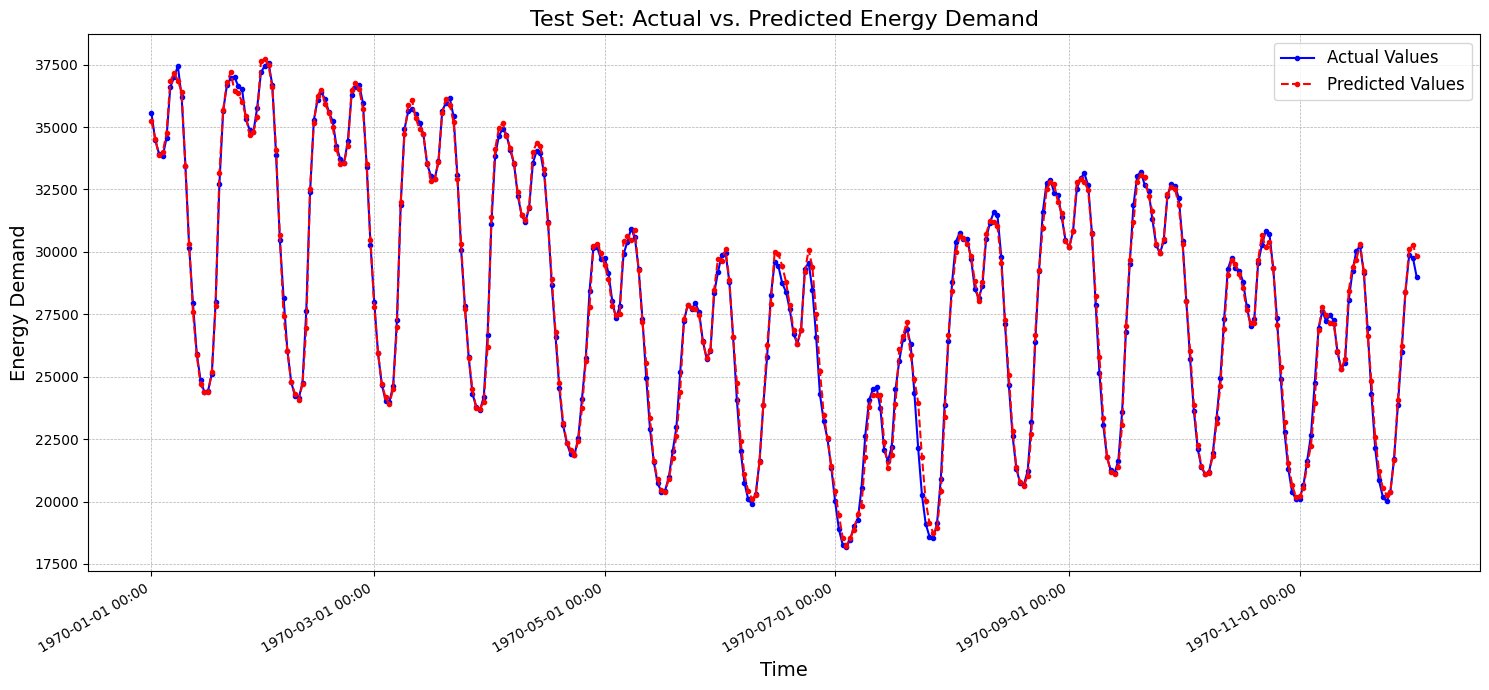

In [44]:
# Plot the reduced and full multivariate predictions
if "actuals" in test_metrics_mv and "predictions" in test_metrics_mv:
    test_actuals = test_metrics_mv["actuals"]
    test_predictions = test_metrics_mv["predictions"]

    n_total = len(target_series)
    val_end_idx_for_plot = int(n_total * (TRAIN_RATIO_MV + VAL_RATIO_MV))

    num_predictions = len(test_predictions)

    test_predictions_start_original_idx = val_end_idx_for_plot + SEQUENCE_LENGTH_MV

    if test_predictions_start_original_idx + num_predictions > n_total:
        print("Warning: Calculated end index for plotting exceeds series length. Adjusting.")
        num_predictions = n_total - test_predictions_start_original_idx

    timestamps_for_plot = target_series.index[
        test_predictions_start_original_idx : test_predictions_start_original_idx + num_predictions
    ]

    if len(timestamps_for_plot) == len(test_actuals) and len(timestamps_for_plot) == len(test_predictions):
        plot_predictions(
            timestamps_for_plot,
            test_actuals,
            test_predictions,
            title="Test Set: Actual vs. Predicted Energy Demand",
            plot_subset_size=24 * 14
        )
    else:
        print("Warning: Mismatch in lengths of timestamps, actuals, or predictions. Skipping plot.")
        print(f"Timestamps length: {len(timestamps_for_plot)}")
        print(f"Actuals length: {len(test_actuals)}")
        print(f"Predictions length: {len(test_predictions)}")

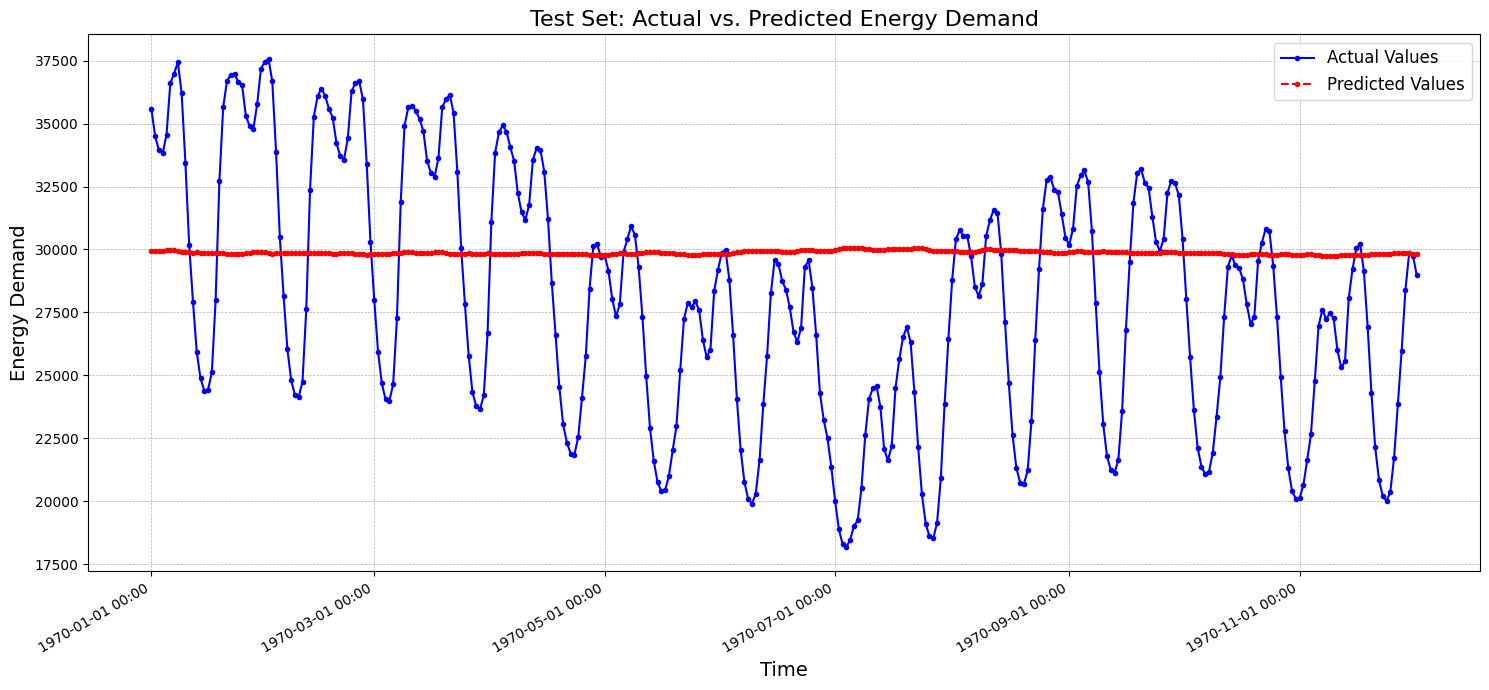

In [45]:
# Plot the reduced and full multivariate predictions
if "actuals" in test_metrics_mv_full and "predictions" in test_metrics_mv_full:
    test_actuals = test_metrics_mv_full["actuals"]
    test_predictions = test_metrics_mv_full["predictions"]

    n_total = len(target_series)
    val_end_idx_for_plot = int(n_total * (TRAIN_RATIO_MV + VAL_RATIO_MV))

    num_predictions = len(test_predictions)

    test_predictions_start_original_idx = val_end_idx_for_plot + SEQUENCE_LENGTH_MV

    if test_predictions_start_original_idx + num_predictions > n_total:
        print("Warning: Calculated end index for plotting exceeds series length. Adjusting.")
        num_predictions = n_total - test_predictions_start_original_idx

    timestamps_for_plot = target_series.index[
        test_predictions_start_original_idx : test_predictions_start_original_idx + num_predictions
    ]

    if len(timestamps_for_plot) == len(test_actuals) and len(timestamps_for_plot) == len(test_predictions):
        plot_predictions(
            timestamps_for_plot,
            test_actuals,
            test_predictions,
            title="Test Set: Actual vs. Predicted Energy Demand",
            plot_subset_size=24 * 14
        )
    else:
        print("Warning: Mismatch in lengths of timestamps, actuals, or predictions. Skipping plot.")
        print(f"Timestamps length: {len(timestamps_for_plot)}")
        print(f"Actuals length: {len(test_actuals)}")
        print(f"Predictions length: {len(test_predictions)}")